# MapMatching Example for enviroCar Tracks

In [5]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd

from packages.envirocar import TrackAPI

track_api = TrackAPI()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<AxesSubplot:>

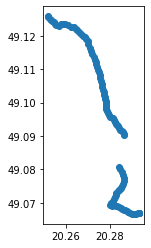

In [4]:
track_df = track_api.get_tracks(num_results=1)
track_df.plot()

## Creating the Graph Network

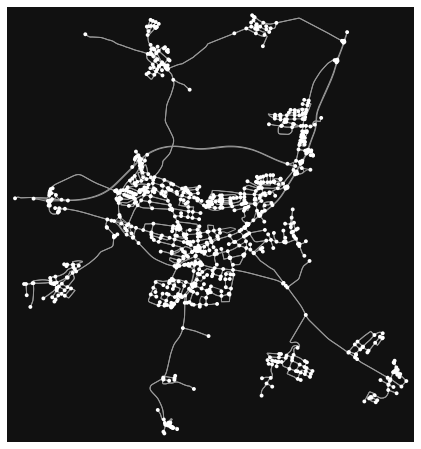

CPU times: user 2.52 s, sys: 332 ms, total: 2.85 s
Wall time: 3.56 s


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [35]:
%%time
import numpy as np
import osmnx as ox

lat = 49.0587587
lng = 20.2973094

# Get the OSM graph of "drive" streets for münster an plot it
graph = ox.graph_from_point((lat, lng), dist=5000, network_type='drive')
ox.plot_graph(graph)

In [36]:
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap

# Leuven Map Matching is using a different internal graph structure for the street data. 
# Therefore, the OSMnx graph needs to be transformed to the InMemMap
streetmap = InMemMap("enviroCar", use_latlon=True, use_rtree=True, index_edges=True)

# add nodes
nodes = list(graph.nodes)
for node in nodes:
    lng = graph.nodes[node]['x']
    lat = graph.nodes[node]['y']
    streetmap.add_node(node, (lat, lng))

# add edges
edges = list(graph.edges)
for edge in edges:
    node_a, node_b = edge[0], edge[1]
    streetmap.add_edge(node_a, node_b)
    
    # exclude bi-directional edges when street is oneway
    if not graph.edges[edge]['oneway']:
        streetmap.add_edge(node_b, node_a)
    
streetmap.purge()

/Users/sampittko/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/sampittko/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## MapMatch the Track

In [37]:
# Get the latitude and longitude coordinates from the track and join them in an array
lats = list(track_df['geometry'].apply(lambda coord: coord.y))
lngs = list(track_df['geometry'].apply(lambda coord: coord.x))

track_coords = [c for c in zip(lats, lngs)]

In [38]:
%%time
# Configure the mapmatcher. For increasing the performance it is important 
# that max_dist (in meters) is not set too high
matcher = DistanceMatcher(streetmap,
                          max_dist=50, 
                          max_dist_init=100,
                          min_prob_norm=0.001,
                          non_emitting_length_factor=0.75,
                          obs_noise=50,
                          obs_noise_ne=75,
                          dist_noise=50,
                          non_emitting_edgeid=False)

# Perform the mapmatching 
edge_ids, last_idx = matcher.match(track_coords)

CPU times: user 474 µs, sys: 80 µs, total: 554 µs
Wall time: 475 µs


In [39]:
import folium

lat = 49.0587587
lng = 20.2973094

# get the coordinates of the "best" mapmatched route
coords = [m.edge_m.pi[:] for m in matcher.lattice_best]

# plot both raw and mapmatched track
m = folium.Map(location=[lat, lng], zoom_start=13)
folium.PolyLine(coords, color='blue').add_to(m)
folium.PolyLine(track_coords, color='red').add_to(m)
m

ValueError: Locations is empty.